# Homework 2: 影像分類，使用 PyTorch

## 下載 CIFAR-10 資料集

In [1]:
# 使用 wget 指令下載資料集
!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz

--2025-10-07 12:18:34--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M   991KB/s    in 2m 35s  

2025-10-07 12:21:10 (1.05 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]



In [2]:
# 使用 tar -xvf 進行解壓縮
# 可參考 https://note.drx.tw/2008/04/command.html
!tar -xvf cifar-10-python.tar.gz

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [3]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple
from PIL import Image
import torch
import torchvision
import os
from sklearn.metrics import accuracy_score

In [4]:
# 觀察 CIFAR-10 的類別

with open("cifar-10-batches-py/batches.meta", "rb") as f:
    label_names = pickle.load(f, encoding='bytes')[b'label_names']
    label_names = [label.decode("utf-8") for label in label_names]

print(label_names)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


## 資料前處理
- 我們再來會用到的檔案是 `data_batch_n` (n=1~5), `test_batch` 等資料
- 因此，我們需要先觀察一下它們的內容


In [5]:
def unpickle(file: str) -> dict:
    with open(file, 'rb') as f:
        dict = pickle.load(f, encoding='bytes')
    return dict

In [6]:
tmp = unpickle("cifar-10-batches-py/data_batch_1")
print(type(tmp))
print(tmp.keys())

<class 'dict'>
dict_keys([b'batch_label', b'labels', b'data', b'filenames'])


In [7]:
print(tmp[b'data'].shape)
print(tmp[b'labels'])
print(type(tmp[b'labels']))
print()
print(tmp[b'data'][0].shape)
print(tmp[b'data'][0])
print(type(tmp[b'data']))

(10000, 3072)
[6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6, 4, 3, 6, 6, 2, 6, 3, 5, 4, 0, 0, 9, 1, 3, 4, 0, 3, 7, 3, 3, 5, 2, 2, 7, 1, 1, 1, 2, 2, 0, 9, 5, 7, 9, 2, 2, 5, 2, 4, 3, 1, 1, 8, 2, 1, 1, 4, 9, 7, 8, 5, 9, 6, 7, 3, 1, 9, 0, 3, 1, 3, 5, 4, 5, 7, 7, 4, 7, 9, 4, 2, 3, 8, 0, 1, 6, 1, 1, 4, 1, 8, 3, 9, 6, 6, 1, 8, 5, 2, 9, 9, 8, 1, 7, 7, 0, 0, 6, 9, 1, 2, 2, 9, 2, 6, 6, 1, 9, 5, 0, 4, 7, 6, 7, 1, 8, 1, 1, 2, 8, 1, 3, 3, 6, 2, 4, 9, 9, 5, 4, 3, 6, 7, 4, 6, 8, 5, 5, 4, 3, 1, 8, 4, 7, 6, 0, 9, 5, 1, 3, 8, 2, 7, 5, 3, 4, 1, 5, 7, 0, 4, 7, 5, 5, 1, 0, 9, 6, 9, 0, 8, 7, 8, 8, 2, 5, 2, 3, 5, 0, 6, 1, 9, 3, 6, 9, 1, 3, 9, 6, 6, 7, 1, 0, 9, 5, 8, 5, 2, 9, 0, 8, 8, 0, 6, 9, 1, 1, 6, 3, 7, 6, 6, 0, 6, 6, 1, 7, 1, 5, 8, 3, 6, 6, 8, 6, 8, 4, 6, 6, 1, 3, 8, 3, 4, 1, 7, 1, 3, 8, 5, 1, 1, 4, 0, 9, 3, 7, 4, 9, 9, 2, 4, 9, 9, 1, 0, 5, 9, 0, 8, 2, 1, 2, 0, 5, 6, 3, 2, 7, 8, 8, 6, 0, 7, 9, 4, 5, 6, 4, 2, 1, 1, 2, 1, 5, 9, 9, 0, 8, 4, 1, 1, 6, 3, 3, 9, 0, 7, 9, 7, 7, 9, 1, 5, 1, 6, 6, 8

### 將影像儲存於對應的類別資料夾

In [ ]:
def save_images_from_batch(
    batch_data: np.ndarray,
    batch_labels: list,
    batch_idx: int,
    split: str,
    output_dir: str,
):
    for i in range(len(batch_data)):
        img_array = batch_data[i] # 每組 batch 的 shape: 張數 x 3096
        label = batch_labels[i]

        img = # TODO1-1: 將 img_array 轉成 3x32x32，再轉成 (Height, Width, Channel) 格式
        img = Image.fromarray(img) # 將數值資料轉為影像資料

        class_dir = # TODO1-2: 建立類別資料夾，讓影像可以存到各自的類別資料夾之中。
        # Hint 1: 因為這個 for loop 一次只會取一筆資料，因此需要 exist_ok=True
        # Hint 2: training 資料夾階層可以是 cifar10/train/`class_id`/train_n_0000.png
        # Hint 3: test 資料夾階層可以是 cifar10/test/`class_id`/test_n_0000.png

        img_filename = os.path.join(class_dir, f"{split}_{batch_idx}_{i:04d}.png")
        img.save(img_filename)

In [ ]:
def convert_raw_to_images(
    cifar_dir: str = "cifar-10-batches-py",
    output_dir: str = "cifar10",
):
    os.makedirs(output_dir, exist_ok=True)

    # 處理訓練集
    for i in range(1, 6):
        batch = unpickle(os.path.join(cifar_dir, f"data_batch_{i}"))
        data = batch[b'data']
        labels = batch[b'labels']
        save_images_from_batch(
            batch_data=data,
            batch_labels=labels,
            batch_idx=i,
            split="train",
            output_dir=output_dir,
        )

    # 處理測試集
    test_batch = unpickle(os.path.join(cifar_dir, "test_batch"))
    save_images_from_batch(
        batch_data=test_batch[b'data'],
        batch_labels=test_batch[b'labels'],
        batch_idx=0,
        split="test",
        output_dir=output_dir,
    )

In [ ]:
# 執行資料前處理

convert_raw_to_images()

處理後的資料夾階層將如下所示
```bash
cifar10/
├── train/
│   ├── 0/
│   │   ├── train_0_0001.png
│   │   ├── train_0_0002.png
│   │   └── ...
│   ├── 1/
│   ├── 2/
│   ├── 3/
│   ├── 4/
│   ├── 5/
│   ├── 6/
│   ├── 7/
│   ├── 8/
│   └── 9/
│
└── test/
    ├── 0/
    ├── 1/
    ├── ...
    └── 9/
```

## 建立 PyTorch Dataset

In [ ]:
class CIFAR10ImageFolder(torch.utils.data.Dataset):
    def __init__(self, root_dir: str, transform=None):
        """
        root_dir: 資料夾路徑，例如 'cifar10/train'
        transform: torchvision.transforms 用來轉換 PIL 圖片
        """
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        class_names = sorted(os.listdir(root_dir)) # 列出 `root_dir` 底下有哪些類別資料夾，並由小至大排序
        for idx, class_name in enumerate(class_names):
            class_folder = os.path.join(root_dir, class_name)
            if not os.path.isdir(class_folder):
                continue

            for filename in os.listdir(class_folder):
                if filename.endswith(('.png', '.jpg')):
                    # TODO2-1: 將所有的檔案路徑都收集到 `self.image_paths`
                    # TODO2-2: 將所有的 label_id 都收集到 `self.labels`

    def __getitem__(self, idx: int):
        img_path = # TODO2-3: 取得 idx 所對應的檔案路徑
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')  # 讀成 RGB 模式

        if self.transform:
            image = self.transform(image)

        return image, label

    def __len__(self):
        return len(self.image_paths)

In [ ]:
# 定義資料數值轉換
transform = torchvision.transforms.Compose([
    # transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),  # (HWC, uint8) → (CHW, float32 [0,1])
    torchvision.transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

In [ ]:
# 建立 Dataset
train_dataset = CIFAR10ImageFolder(root_dir='cifar10/train', transform=transform)
test_dataset = CIFAR10ImageFolder(root_dir='cifar10/test', transform=transform)

In [ ]:
train_labels = [example[1] for example in train_dataset]
test_labels = [example[1] for example in test_dataset]

In [ ]:
import collections
print(collections.Counter(train_labels))
print(collections.Counter(test_labels))

Counter({0: 5000, 1: 5000, 2: 5000, 3: 5000, 4: 5000, 5: 5000, 6: 5000, 7: 5000, 8: 5000, 9: 5000})
Counter({0: 1000, 1: 1000, 2: 1000, 3: 1000, 4: 1000, 5: 1000, 6: 1000, 7: 1000, 8: 1000, 9: 1000})


In [ ]:
# 從 train_dataset 切出 validation_dataset

from torch.utils.data import random_split

validation_ratio = 0.2
total_len = len(train_dataset)
val_size = int(validation_ratio * total_len)
train_size = total_len - val_size

train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

## 超參數

In [ ]:
LR = 0.001
train_batch_size = 64
test_batch_size = 128
num_epochs = 10

## 建立 DataLoader

In [ ]:
# TODO3: 建立 DataLoader (train / valid / test)
train_loader = torch.utils.data.DataLoader(
    # Write your code here
)
val_loader = torch.utils.data.DataLoader(
    # Write your code here
)
test_loader = torch.utils.data.DataLoader(
    # Write your code here
)

# 簡單驗證一個 batch
for images, labels in test_loader:
    print("Image shape:", images.shape)  # [B, 3, 32, 32]
    print("Label shape:", labels.shape)  # [B]
    break

Image shape: torch.Size([128, 3, 32, 32])
Label shape: torch.Size([128])


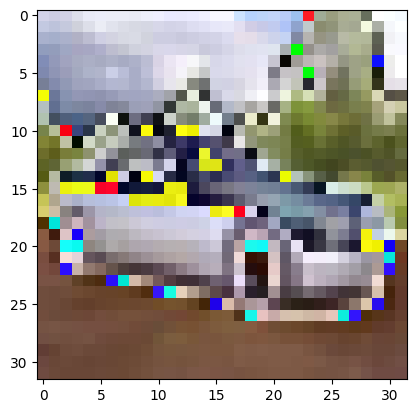

In [ ]:
# 驗證一個 example
example_img, example_label = train_dataset[0]

example = example_img.numpy() # shape: (3, 32, 32)，因為要印出影像，所以需要先轉回 numpy
example = example.transpose(1, 2, 0) # shape: (32, 32, 3)，把 channels 放在最後面

plt.imshow(Image.fromarray((example*255).astype('uint8')))

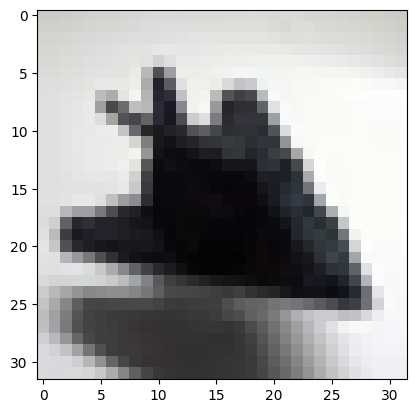

In [ ]:
# 你也可以單純指定一張影像的位置，來印出它
image = Image.open('cifar10/train/0/train_1_0029.png')
plt.imshow(image)

## 建立模型
- 影像在進行每層 convolution 後的 feature map 大小公式 (本公式中的 padding 為 0 或 1)：
$$
\mathrm{output\_size} = \frac{\mathrm{input\_size} - \mathrm{kernel\_size} + 2*\mathrm{padding}}{\mathrm{stride}} + 1
$$

In [ ]:
class SimpleCNN(torch.nn.Module):
    def __init__(self, num_classes=10, fc_hidden_size=256, dropout_ratio=0.5):
        super().__init__()

        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = torch.nn.Conv2d(64, 128, kernel_size=3, padding=1)

        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2) # 2x2 pooling

        self.fc1 = torch.nn.Linear(128 * 4 * 4, fc_hidden_size)
        self.fc2 = torch.nn.Linear(fc_hidden_size, num_classes)
        self.relu = torch.nn.ReLU() # 非線性轉換

        self.dropout = torch.nn.Dropout(dropout_ratio)

    def forward(self, x):
        # TODO4: 加入 conv1 layer
        # Write your code here
        x = self.pool(x)
        # conv1: output_size = (32 - 3 + 2 * 1) / 1 + 1 = 32
        # pooling: output_size = (32 - 3 + 2 * 0) / 2 + 1 = 15.5 (進位為 16)

        # TODO4: 加入 conv2 layer
        # Write your code here
        x = self.pool(x)
        # conv2: output_size = (16 - 3 + 2 * 1) / 1 + 1 = 16
        # pooling: output_size = (16 - 3 + 2 * 0) / 2 + 1 = 7.5 (進位為 8)

        # TODO4: 加入 conv3 layer
        # Write your code here
        x = self.pool(x)   # shape: (B, 128, 4, 4)
        # conv3: output_size = (8 - 3 + 2 * 1) / 1 + 1 = 8
        # pooling: output_size = (8 - 3 + 2 * 0) / 2 + 1 = 3.5 (進位為 4)

        x = x.view(x.size(0), -1)  # Flatten, shape: (B, 128*4*4)
        x = # TODO4: 加入 fc1 layer
        x = # TODO4: 加入 fc2 layer
        return x

## 訓練模型

In [ ]:
# 設定設備
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
# 初始化模型、損失函數、optimizer
model = SimpleCNN().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

Epoch 1/10, Train Loss: 1.5670, Val Loss: 1.2666
Epoch 2/10, Train Loss: 1.1846, Val Loss: 1.0296
Epoch 3/10, Train Loss: 0.9996, Val Loss: 0.8619
Epoch 4/10, Train Loss: 0.8725, Val Loss: 0.8180
Epoch 5/10, Train Loss: 0.7822, Val Loss: 0.7831
Epoch 6/10, Train Loss: 0.7114, Val Loss: 0.7562
Epoch 7/10, Train Loss: 0.6462, Val Loss: 0.7264
Epoch 8/10, Train Loss: 0.5883, Val Loss: 0.7337
Epoch 9/10, Train Loss: 0.5305, Val Loss: 0.7431
Epoch 10/10, Train Loss: 0.4875, Val Loss: 0.7483


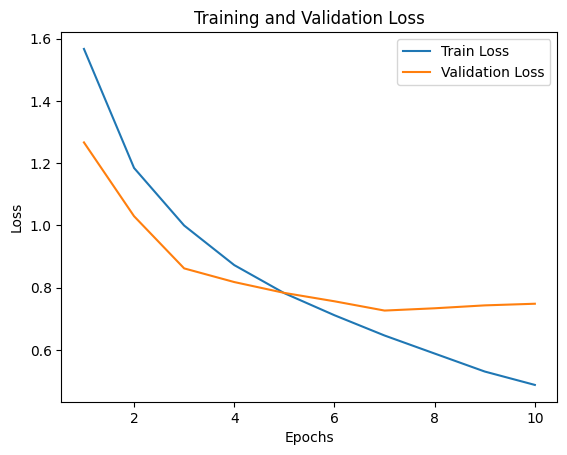

In [ ]:
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    # TODO5: 請實作 training 流程

    # 驗證模型
    model.eval()
    val_loss = 0.0
    # TODO6: 請實作 validation 流程

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')

# 繪製 loss 的歷史記錄圖
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
model.eval()
predictions = []
test_loss = 0.0 # 在 test 的時候其實不用算 loss，因為通常我們沒有 test set 的標準答案
test_losses = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        tmp_pred = outputs.argmax(dim=1) # tmp_pred 的型態是 tensor
        predictions.extend(tmp_pred.tolist()) # 如果用 append 的話會變成 [[1, 2, 3], [4, 5, 6]]

        loss = criterion(outputs, labels)
        test_loss += loss.item()
test_losses.append(test_loss / len(test_loader))

In [ ]:
# test_labels = [example[1] for example in test_dataset]

In [ ]:
accuracy_score(test_labels, predictions)

0.7508